[20220820]

# 1. Data Inspections

Brief inspections of the data.

## Goal
To check a summary of the data.

## Plan
Checklist what will be done on the notebook :

        [ ] Create an identifier column (if not exist)
        [ ] Or Creating Datamart if there are many resources
        [ ] Columns and Rows Counts
        [ ] Target Descriptions
        [ ] Possible Variable
        [ ] Train and Test separation

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
sys.path.insert(1,'../../src/')

## import myfunc inside src folder
import ramal

In [2]:
with open("../../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

PATH_RAW = config['path']['raw_wm']
PATH_INTERIM = config['path']['interim']
PATH_PROCESSED = config['path']['processed']
PATH_MODEL = config['path']['artifact']+os.getcwd().split('\\')[-1]+'/'
PATH_UDF = config['path']['udf']

## Get Data

In [3]:
df = pd.read_csv(PATH_RAW+'train.csv')

In [4]:
df.shape

(421570, 5)

In [5]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


## Check Identifier Column

Looking/Creating a column which seperate each rows.

In [6]:
df['ids'] = df['Store'].astype(str) + ':' + df['Dept'].astype(str)

In [7]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,ids
0,1,1,2010-02-05,24924.50,False,1:1
1,1,1,2010-02-12,46039.49,True,1:1
2,1,1,2010-02-19,41595.55,False,1:1
3,1,1,2010-02-26,19403.54,False,1:1
4,1,1,2010-03-05,21827.90,False,1:1


## Prepare The Timeseries

In [8]:
## fillna the unlisted week

df_sales = df.groupby(['ids','Date'])['Weekly_Sales'].sum().unstack().fillna(0).stack().reset_index()
df_sales.rename(columns = {0:'wsales'}, inplace =True)
df_sales.sample(5)

,ids,Date,wsales
170485,24:41,2010-08-27,1995.80
283085,34:1,2011-10-14,20956.74
243723,30:14,2011-01-28,642.64
101177,19:21,2011-07-22,6252.95
213223,28:32,2010-04-16,6441.81


In [10]:
df.shape, df_sales.shape

((421570, 6), (476333, 3))

In [11]:
df_sales2 = pd.merge(df_sales, df[['ids','Date','IsHoliday']], on = ['ids','Date'], how = 'left')

## Data Summary

In [12]:
hd_product = df_sales2.groupby('ids')['wsales'].sum().sort_values(ascending = False)

hd_product[:10]

ids
14:92    26101497.71
2:92     23572153.03
20:92    23542625.04
13:92    23170876.20
4:92     22789210.43
20:95    21537795.62
4:95     21054815.74
27:92    20952094.22
14:95    20655911.35
2:95     20533191.52
Name: wsales, dtype: float64

In [16]:
len(hd_product)

3331

In [14]:
# hd_product[:25].sample(8).index
product_focus =['3:38', '2:95', '1:92', '14:90', '10:72', '13:92', '31:92', '1:95']

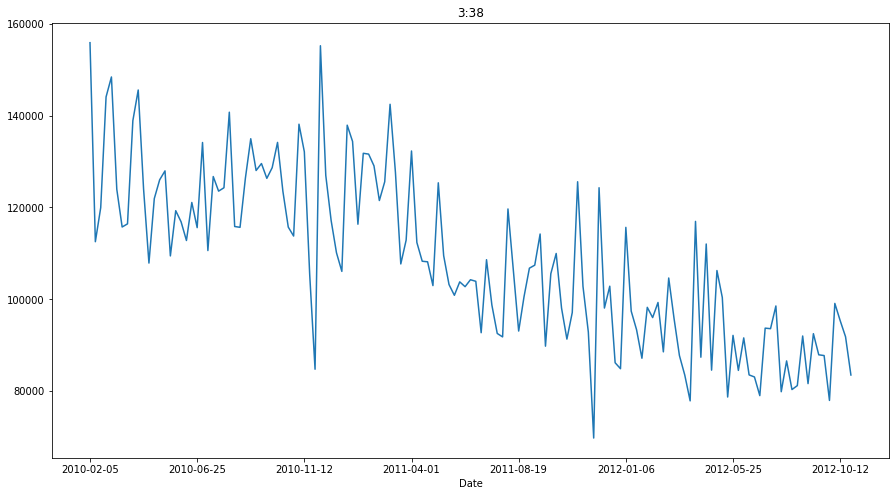

<Figure size 432x288 with 0 Axes>

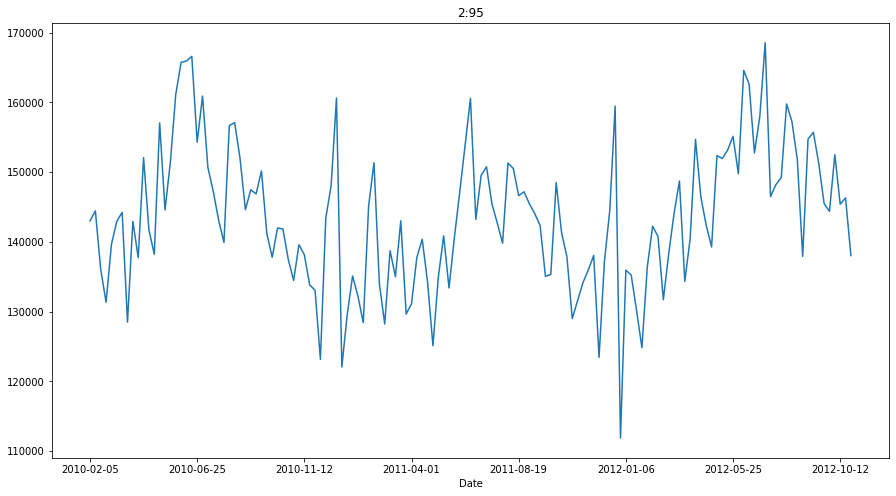

<Figure size 432x288 with 0 Axes>

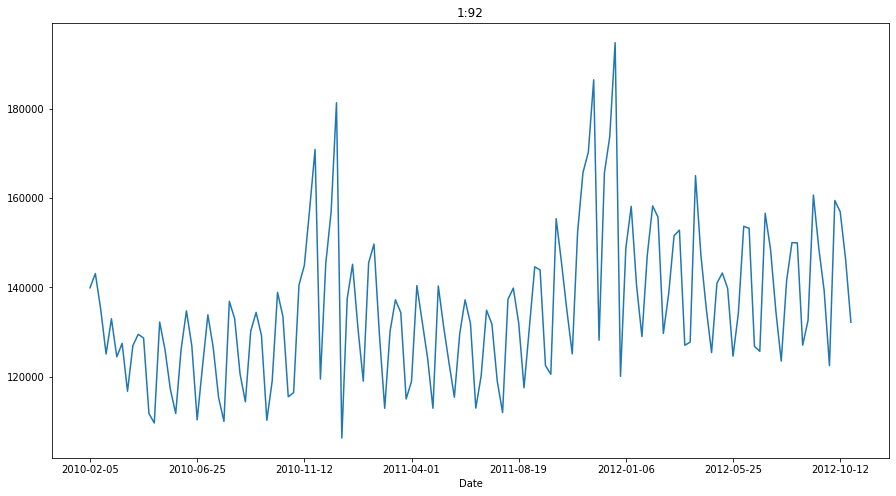

<Figure size 432x288 with 0 Axes>

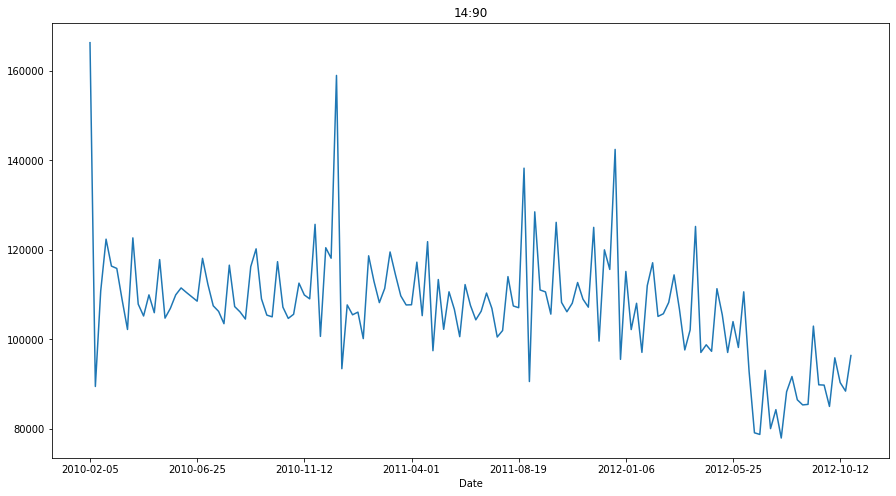

<Figure size 432x288 with 0 Axes>

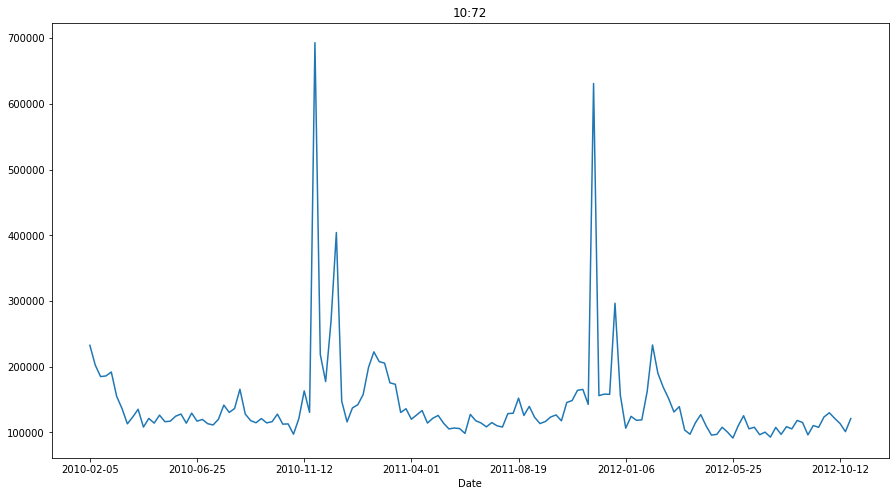

<Figure size 432x288 with 0 Axes>

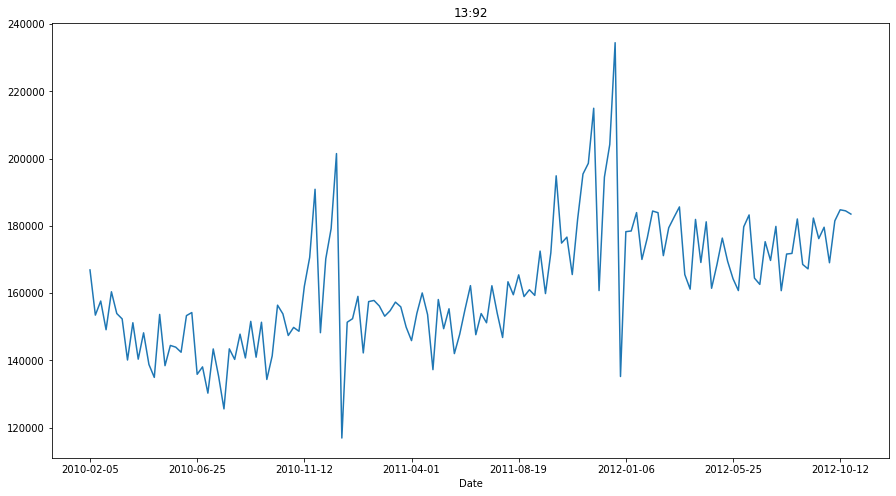

<Figure size 432x288 with 0 Axes>

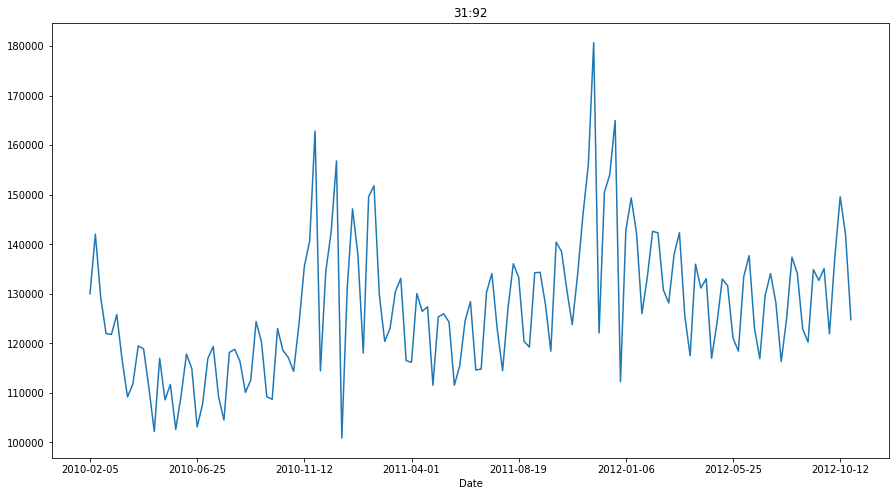

<Figure size 432x288 with 0 Axes>

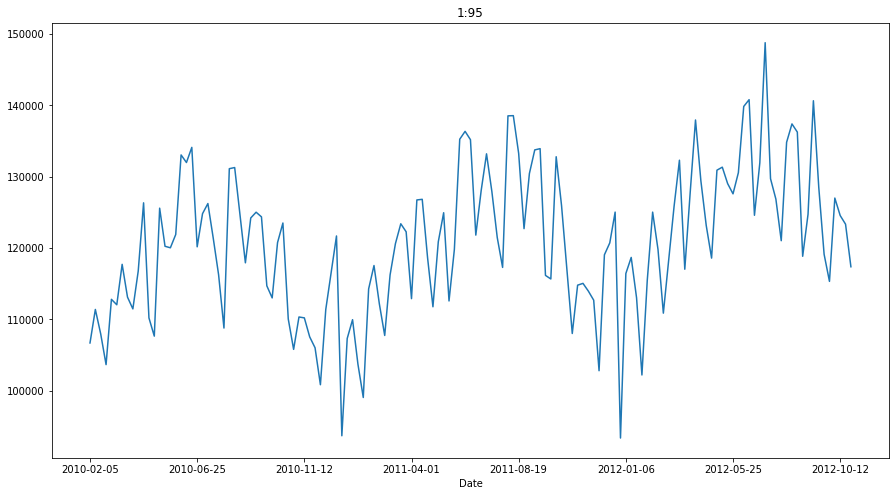

<Figure size 432x288 with 0 Axes>

In [15]:
for i in product_focus:
    plt.figure(figsize = (15,8))
    ramal.plot_per_product(df = df_sales2, data_col = 'wsales', pr_id = i)
    plt.show()
    plt.clf()

## Save to Interim

Seperate the data (Train and Test) to interim folder

In [17]:
df_sales3 = df_sales2[df_sales2['ids'].isin(product_focus)]

In [18]:
df_sales3.to_csv(PATH_INTERIM+'data_focus_iter1.csv',index = False)